# Loading , transform, and model solar array data

## Aim of this notebook is to compare observed and theoretical model outputs as a first step to selecting physics-driven features for ML

In [1]:
import pandas as pd


In [70]:
def proccess_annual_data(df):
    df.index=pd.to_datetime(df.Timestamp)
    cols = list(df.columns)
    power_cols = [s for s in cols if 'Active Power' in s and s[0].isdigit()]
    weather_cols = [s for s in cols if 'WeatherStation' in s]
    
    select_cols = power_cols + weather_cols
    
    new_power_cols = [s.split(' ')[0] for s in power_cols]
    new_weather_cols = [s.replace('DKA.WeatherStation - ',"") for s in weather_cols]
    
    new_cols = new_power_cols + new_weather_cols
    
    power_data = df[select_cols].fillna('0')
    power_data.columns = new_cols
    power_data=power_data.astype(float)
    
    return power_data, new_power_cols, new_weather_cols

def read_combine_data(year_range):
    # reads, cleans, and concats raw dataframes
    master_data = pd.DataFrame()

    for year in year_range:
        df = pd.read_csv('Alice_Springs_'+str(year)+'.csv')
        print('Extracting '+str(year))
        df, new_power_cols, new_weather_cols = proccess_annual_data(df)
        master_data = master_data.append(df, sort=False)
    
    return master_data, new_power_cols, new_weather_cols


def norm_av_df(df):
    # creats normalised average daily patterns for time series data
    
    df_av = df.groupby(df.index.hour).mean()  # average value for each hour of the day
    
    df_norm = (df-df.min())/(df.max()-df.min())
    
    df_av_norm = (df_av-df_av.min())/(df_av.max()-df_av.min()) # normalise the data set for comparative analysis
    
    return df_av, df_norm, df_av_norm

    
def clean_meta_data(panel_meta_data):
    #cleans raw meta data into readable features

    # creat boolian for fixed or tracking

    panel_meta_data['Is Fixed?'] = panel_meta_data['Array Structure'].str.contains('Fixed')

    # extract tilt and azimuth
    import re
    panel_meta_data['Array Tilt/Azimuth']=panel_meta_data['Array Tilt/Azimuth'].astype('str')

    angles = panel_meta_data['Array Tilt/Azimuth'].apply(lambda x: re.findall("\d+", x))

    azimuth = []
    tilt = []

    for item in angles:
        try:
            azimuth.append(int(item[1]))
        except:
            azimuth.append(0)

        try:
            tilt.append(int(item[0]))
        except:
            tilt.append(0)

    panel_meta_data['Tilt'] = tilt
    panel_meta_data['Azim'] = azimuth

    #extract array area
    panel_meta_data['Array Area']=panel_meta_data['Array Area'].astype('str')

    area_data = panel_meta_data['Array Area'].apply(lambda x: re.findall("\d*\.?\d+", x))

    areas=[]
    for item in area_data:
        try:
            try:
                areas.append(float(item[0])*float(item[1]))
            except:
                areas.append(float(item[0]))
        except:
            areas.append(0)

    panel_meta_data['Array Area (m2)'] = areas
    #panel_meta_data = panel_meta_data.drop('Array Area', axis =1)


    panel_meta_data['Array Rating (kW)'] = panel_meta_data['Array Rating'].str.replace('kW','').astype(float)
    #panel_meta_data = panel_meta_data.drop('Array Rating', axis =1)

    panel_meta_data['Panel Rating (W)'] = panel_meta_data['Panel Rating'].str.replace('W','').astype(float)

    # number of Panels
    panel_meta_data['Number Of Panels']=panel_meta_data['Number Of Panels'].astype('str')

    panel_data = panel_meta_data['Number Of Panels'].apply(lambda x: re.findall("\d*\.?\d+", x))

    panels=[]
    for item in panel_data:
        try:
            try:
                panels.append(int(item[0])*int(item[1]))
            except:
                panels.append(int(item[0]))
        except:
            panels.append(0)

    panel_meta_data['Number Of Panels (int)'] = panels

    panel_meta_data['Installation Completed (datetime)']=pd.to_datetime(panel_meta_data['Installation Completed'] )

    pv_tech_dummies = pd.get_dummies(panel_meta_data['PV Technology'])
    structure_dummies = pd.get_dummies(panel_meta_data['Array Structure'])


    panel_meta_data = pd.concat([panel_meta_data, pv_tech_dummies], axis=1, sort=False)
    panel_meta_data = pd.concat([panel_meta_data, structure_dummies], axis=1, sort=False)
    
    return panel_meta_data

# Inter-annual performance deccline

In [65]:
import statsmodels.api as sm
from scipy import stats

def normalised_decomposition(master_data,start,end):
    
    resampled = master_data[start:end].resample('W').mean()
    resampled = resampled.fillna('0').astype('float')
    normalized =(resampled-resampled.min())/(resampled.max()-resampled.min())
    decomposition = sm.tsa.seasonal_decompose(normalized, model='additive')
    
    return normalized, decomposition


def identify_ouput_decline(data, start, end, p_val):
     
    trend_stats = pd.DataFrame()
    
    for col in data.columns:
        sample = data.loc[start:end, col]
        x = list(range(len(sample)))
        y = sample.values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        trend_stats.loc[col,'slope'] = slope
        trend_stats.loc[col,'intercept'] = intercept
        trend_stats.loc[col,'r_value'] = r_value
        trend_stats.loc[col,'p_value'] = p_value
        downs = trend_stats[(trend_stats.slope < 0)&(trend_stats.p_value < p_val)].index.values
    return trend_stats, downs


In [49]:

year_range = (2018,2019)
data, new_power_cols, new_weather_cols = read_combine_data(year_range)


Extracting 2018
Extracting 2019


In [71]:
data_av, data_norm, data_av_norm = norm_av_df(data)

In [37]:
panel_meta_data = pd.read_csv('panel_meta_data.csv',index_col=0)
panel_meta_data = clean_meta_data(panel_meta_data)

In [41]:
fixed_mask = panel_meta_data[panel_meta_data['Is Fixed?']].index.values

In [55]:
fixed_mask = list(set(fixed_mask).intersection(set(new_power_cols)))
tracking_mask = list(set(new_power_cols).difference(set(fixed_mask)))

# Explore data

In [46]:
data = pd.read_csv('Alice_Springs_2018.csv')

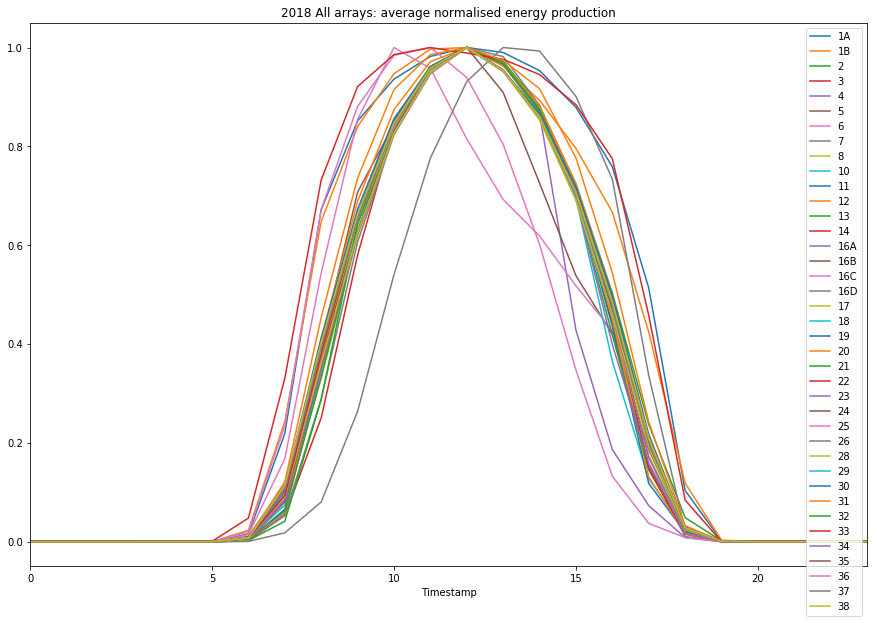

In [139]:
data_av_norm[new_power_cols].plot(figsize=(15,10), title = '2018 All arrays: average normalised energy production')


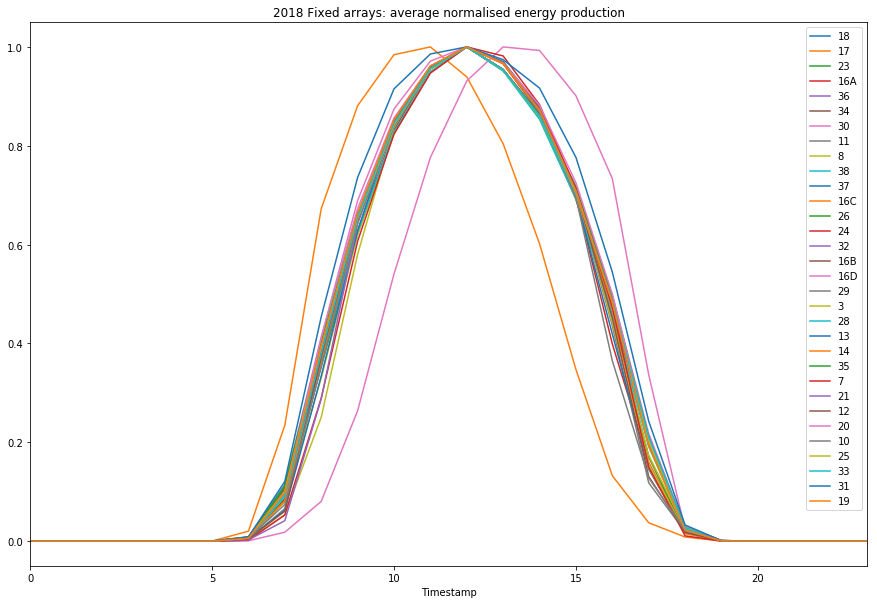

In [140]:
data_av_norm[fixed_mask].plot(figsize=(15,10),title = '2018 Fixed arrays: average normalised energy production')


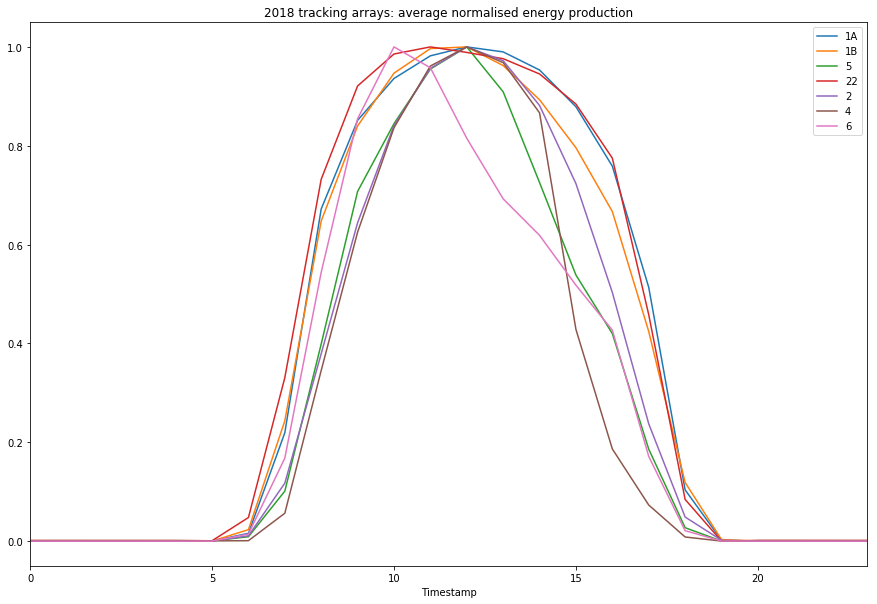

In [141]:
data_av_norm[tracking_mask].plot(figsize=(15,10), title = '2018 tracking arrays: average normalised energy production')

In [61]:
test = data_av_norm.loc[:,fixed_mask]
test = test[test==1].dropna(how='all')
test

,18,17,23,16A,36,34,30,11,8,38,...,35,7,21,12,20,10,25,33,31,19
Timestamp,,,,,,,,,,,,,,,,,,,,,
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
print(test.loc[11][-test.loc[11].isna()])
print(test.loc[13][-test.loc[13].isna()])

16C    1.0
Name: 11, dtype: float64
16D    1.0
Name: 13, dtype: float64


# Multi Annual Trend Detection

In [76]:
resampled = data_norm[new_power_cols].resample('W').mean()
trend_stats, downs = identify_ouput_decline(resampled,'2018','2019',1e-3)

In [77]:
trend_stats.loc[downs]

,slope,intercept,r_value,p_value
1B,-0.001488,0.248539,-0.751683,9.427729e-16
6,-0.001276,0.234372,-0.679098,4.394480e-12
17,-0.002486,0.278077,-0.548613,1.375937e-07


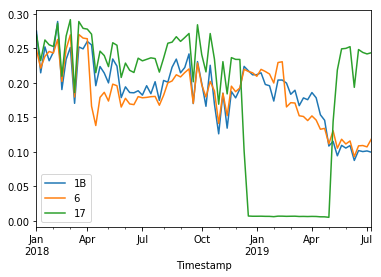

In [78]:
resampled.loc['2018':'2019',downs].plot()

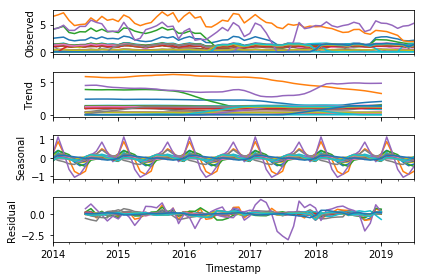

In [27]:
import matplotlib.pyplot as plt
fig = decomposition.plot()
plt.show()

In [79]:
# Comparison with Physical Model

In [80]:
from pvlib.location import Location

#Desert Knowledge Australia Solar Centre (DKASC) 
# Creat a location object
DKASC = Location(23.7618, 133.8749, 'Australia/South', 583,'DKASC')
print(DKASC)

Location: 
  name: DKASC
  latitude: 23.7618
  longitude: 133.8749
  altitude: 583
  tz: Australia/South


In [83]:
# localize the timestamp data: error handling required, investigate further
data.index = data.index.tz_localize('Australia/South',ambiguous = "NaT",nonexistent="NaT")
data = data[~data.index.duplicated()]  

In [85]:
# recalculate average and normalised curves for observed data
data_av , data_norm, data_av_norm = norm_av_df(data)

2018-05-05 23:55:00+09:30
2018-05-05 23:55:00+09:30


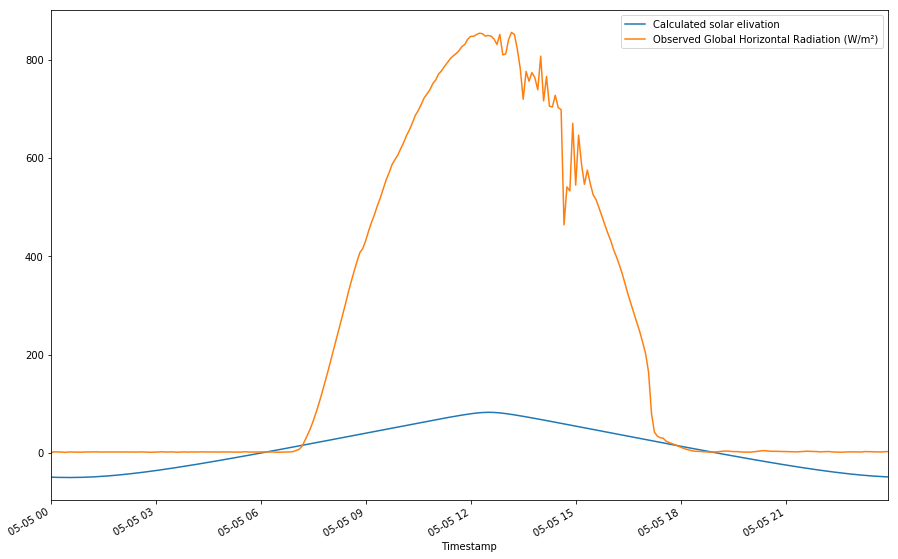

In [143]:
import pvlib

times_au = data.index
spaout_australia = pvlib.solarposition.spa_python(times_au, DKASC.latitude, DKASC.longitude)
spaout_australia.loc['2018-05-05','elevation'].plot(label = 'Calculated solar elivation', legend = True, figsize =(15,10))
data.loc['2018-05-05','Global Horizontal Radiation (W/m²)'].plot(label = 'Observed Global Horizontal Radiation (W/m²)', legend = True)

x1=data.loc['2018-05-05','Global Horizontal Radiation (W/m²)'].index.max()
x2 = spaout_australia.loc['2018-05-05','elevation'].index.max()


print(x1)
print(x2)


In [86]:
# Next we need to decompose the radiation into its constituent components

from pvlib.irradiance import dni 
#https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.dni.html#pvlib.irradiance.dni

GHI = data['Global Horizontal Radiation (W/m²)']
DHI = data['Diffuse Horizontal Radiation (W/m²)']
zenith = spaout_australia['zenith']

DNI= dni(GHI,DHI,zenith)
DNI = DNI.fillna(0)

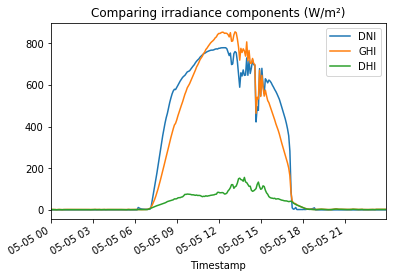

In [145]:
#examine outputs for given date
date = '2018-05-05'


DNI[date].plot(label='DNI', legend=True, title = 'Comparing irradiance components (W/m²)')
DNI = DNI.fillna(0)
GHI[date].plot(label='GHI', legend=True)
DHI[date].plot(label='DHI', legend=True)

https://www.quora.com/Can-global-irradiation-be-less-than-direct-normal-irradiation

In [89]:
# lets now try modelling the radiation incident on the solar pannels
from pvlib.irradiance import get_total_irradiance
solar_azimuth = spaout_australia['azimuth']
solar_zenith = spaout_australia['zenith']
surface_tilt = 20
surface_azimuth = 270

#calculate for 16D azimuth of 270 degrees
sixteenD_irr = get_total_irradiance(surface_tilt,270,solar_zenith,solar_azimuth,DNI,GHI,DHI)
sixteenD_irr_av, sixteenD_irr_norm, sixteenD_irr_av_norm = norm_av_df(sixteenD_irr)


#calculate for 16D azimuth of 90 degrees
sixteenC_irr = get_total_irradiance(surface_tilt,90,solar_zenith,solar_azimuth,DNI,GHI,DHI)
sixteenC_irr_av, sixteenC_irr_norm, sixteenC_irr_av_norm = norm_av_df(sixteenC_irr)

#calculate for other fixed panels with zero azimuth
others_irr = get_total_irradiance(surface_tilt,0,solar_zenith,solar_azimuth,DNI,GHI,DHI)
others_irr_av, others_irr_norm, others_irr_av_norm = norm_av_df(others_irr)


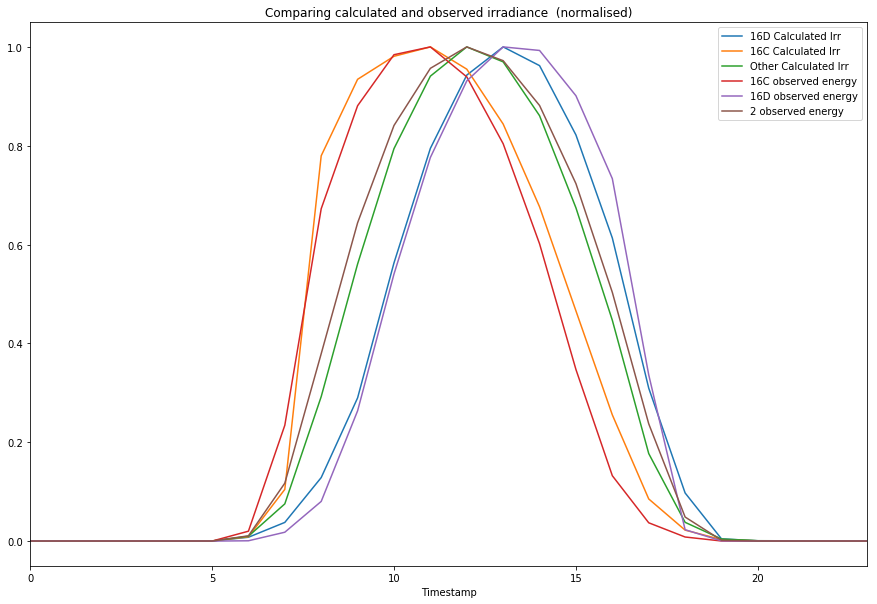

In [147]:
#surface_tilt, surface_azimuth, solar_zenith, solar_azimuth, dni, ghi, dhi

date = '2018-09-08'

sixteenD_irr_av_norm.poa_global.plot(label='16D Calculated Irr', legend= True, figsize = (15,10))

sixteenC_irr_av_norm.poa_global.plot(label='16C Calculated Irr', legend= True)


others_irr_av_norm.poa_global.plot(label='Other Calculated Irr', legend= True)

data_av_norm['16C'].plot(label='16C observed energy', legend= True)

data_av_norm['16D'].plot(label='16D observed energy', legend= True)

data_av_norm['2'].plot(label='2 observed energy', legend= True , 
                       title = 'Comparing calculated and observed irradiance  (normalised)')


#pv_data_averages_normed['16D'].plot()


Good, it looks like we are on the right track concerning simulations of the timing and shape of incoming radiation upon the arrays: the effect of a non-zero azimuth has been captured by the model.

# Total theoretical energy incident on the array: fixed arrays

In [100]:
thoeretical_engery = pd.DataFrame(index = data.index, columns = fixed_mask)



In [114]:
for array in fixed_mask:
    area =  panel_meta_data.loc[array,'Array Area (m2)']
    thoeretical_engery[array] = (others_irr.poa_global * area) / 1000 #kW




In [115]:
thoeretical_engery.head()

,18,17,23,16A,36,34,30,11,8,38,...,35,7,21,12,20,10,25,33,31,19
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+10:30,0.060277,0.083222,0.171063,0.033218,0.0,0.080296,0.081616,0.083046,0.209077,0.146952,...,0.079856,0.152056,0.083024,0.083156,0.077260,0.073916,0.080824,0.079702,0.147392,0.077260
2018-01-01 00:05:00+10:30,0.062926,0.086879,0.178581,0.034678,0.0,0.083824,0.085202,0.086695,0.218265,0.153410,...,0.083365,0.158738,0.086672,0.086810,0.080655,0.077164,0.084376,0.083204,0.153870,0.080655
2018-01-01 00:10:00+10:30,0.041636,0.057486,0.118162,0.022946,0.0,0.055464,0.056376,0.057364,0.144420,0.101508,...,0.055161,0.105033,0.057349,0.057440,0.053367,0.051058,0.055829,0.055054,0.101812,0.053367
2018-01-01 00:15:00+10:30,0.016876,0.023300,0.047893,0.009300,0.0,0.022481,0.022850,0.023251,0.058536,0.041143,...,0.022358,0.042572,0.023245,0.023281,0.021631,0.020695,0.022629,0.022315,0.041266,0.021631
2018-01-01 00:20:00+10:30,0.016927,0.023371,0.048039,0.009329,0.0,0.022549,0.022920,0.023321,0.058714,0.041268,...,0.022426,0.042701,0.023315,0.023352,0.021697,0.020758,0.022697,0.022382,0.041391,0.021697


In [110]:
date = '2018-09-08'

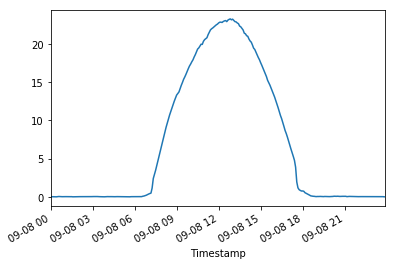

In [116]:
thoeretical_engery.loc[date,'18'].plot()

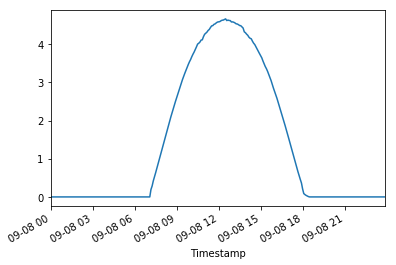

In [117]:
data.loc[date,'18'].plot()

In [130]:
test = pd.read_csv('Alice_Springs_2018.csv')
test.index = pd.to_datetime(test.Timestamp)
list(test.columns)

['Timestamp',
 'Canadian Solar - Active Energy Delivered-Received (kWh)',
 'Canadian Solar - Current Phase Average (A)',
 'Canadian Solar - Active Power (kW)',
 'Canadian Solar - Performance Ratio (%)',
 'Q CELLS - Active Energy Delivered-Received (kWh)',
 'Q CELLS - Current Phase Average (A)',
 'Q CELLS - Active Power (kW)',
 'Q CELLS - Performance Ratio (%)',
 'Q CELLS - Active Energy Delivered-Received (kWh).1',
 'Q CELLS - Current Phase Average (A).1',
 'Q CELLS - Active Power (kW).1',
 'Q CELLS - Performance Ratio (%).1',
 'Q CELLS - Active Energy Delivered-Received (kWh).2',
 'Q CELLS - Current Phase Average (A).2',
 'Q CELLS - Active Power (kW).2',
 'Solco - Active Energy Delivered-Received (kWh)',
 'Solco - Current Phase Average (A)',
 'Solco - Active Power (kW)',
 'Solco - Performance Ratio (%)',
 '1A Trina - Active Energy Delivered-Received (kWh)',
 '1A Trina - Current Phase Average (A)',
 '1A Trina - Active Power (kW)',
 '1B Trina - Active Energy Delivered-Received (kWh)',
 

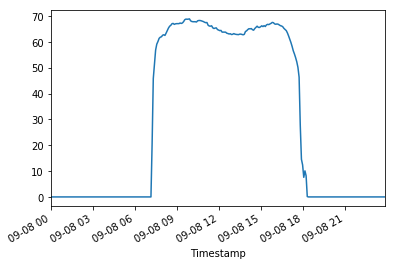

In [149]:
test.loc[date,'16A BP Solar - Performance Ratio (%)'].plot()

In [134]:
performance= data[fixed_mask]/thoeretical_engery

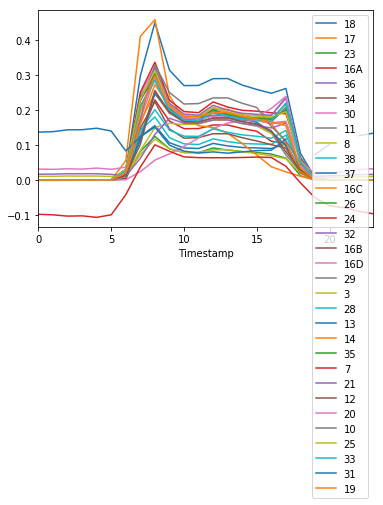

In [148]:
performance.groupby(performance.index.hour).mean().plot()

similar shape, however the observed data is claiming a much higher ratio: this is because we haven't factored in the "solar panel yield or efficiency(%)" which is a further coefficient:

       E = A * r * H * PR

E = Energy (kWh)

A = Total solar panel Area (m2) 

r = solar panel yield or efficiency(%) 

H = Annual average solar radiation on tilted panels (shadings not included)

PR = Performance ratio, coefficient for losses (range between 0.5 and 0.9, default value = 0.75)

/Users/garethwalker/anaconda3/envs/DataChallenge/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


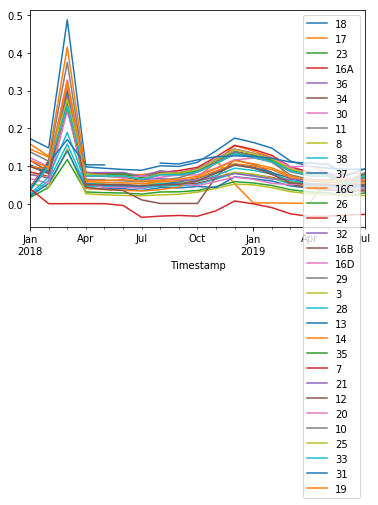

In [135]:
performance.resample('M').mean().plot()